<a href="https://colab.research.google.com/github/yongsa-nut/TU_CN409_GenAI_67_2/blob/main/CN409_Lecture_5_RAG_Demo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# CN 409 - Lecture 5: RAG Demo

## Setting up LLM

Gemini version

In [1]:
%pip install --upgrade --quiet google-genai

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 130.7/130.7 kB 3.2 MB/s eta 0:00:00


In [ ]:
!gcloud auth application-default login

In [ ]:
!gcloud auth application-default set-quota-project cn409-genai-672 # replace the last one with your project ID

In [7]:
import os
from google import genai

PROJECT_ID = "cn409-genai-672"

LOCATION = os.environ.get("GOOGLE_CLOUD_REGION", "us-central1")

client = genai.Client(vertexai=True, project=PROJECT_ID, location=LOCATION)

In [10]:
def generate(prompt):
  # This can be any LLM for this lecture
  response = client.models.generate_content(
    model="gemini-2.0-flash-001", contents=prompt
  )
  return response.text

print(generate("Hello"))

Hello! How can I help you today?



<br>

---

## Demo 1: Keyword Matching

In [11]:
# The data
lorebook = { 'ตึกวิจัย' : 'ตำแหน่ง latitude = 14.0694899, longitude = 100.6050282',
             'ตึกอำนวยการ' : 'ตำแหน่ง latitude = 14.0690024, longitude = 100.6061611'
}

In [12]:
def keyword_generate(query, docs):
  # Retrive information and create context
  context = '<context>'
  for k in docs:
    if k in query:
      context += f'{k} = {docs[k]}\n'
  context += '</context>'

  prompt = f'''<question>{query}</question>
  Please use context in <context> tags to answer the question.
  <context>{context}</context>'''
  response = generate(prompt)
  # printing out
  print('Query:', query)
  print('Retrieved documents:', context)
  print('Response:', response)

query = 'ตึกวิจัยอยู่ไหน?'

keyword_generate(query, lorebook)

Query: ตึกวิจัยอยู่ไหน?
Retrieved documents: <context>ตึกวิจัย = ตำแหน่ง latitude = 14.0694899, longitude = 100.6050282
</context>
Response: ตึกวิจัยอยู่ที่ตำแหน่ง latitude 14.0694899, longitude 100.6050282



<br>

---

## Demo 2: BM25

In [ ]:
# Install necessary libraries
!pip install rank_bm25

In [14]:
from rank_bm25 import BM25Okapi

In [15]:
# Sample document collection
documents = [
    "The quick brown fox jumps over the lazy dog.",
    "A journey of a thousand miles begins with a single step.",
    "To be or not to be, that is the question.",
    "All that glitters is not gold.",
    "Where there's smoke, there's fire.",
    "The early bird catches the worm.",
    "Actions speak louder than words.",
    "Knowledge is power, but enthusiasm pulls the switch.",
    "The pen is mightier than the sword.",
    "When life gives you lemons, make lemonade."
]

# Simple tokenization using string splitting
tokenized_docs = [doc.lower().split() for doc in documents]

# Create BM25 object
bm25 = BM25Okapi(tokenized_docs)

In [16]:
def retrieve(query, top_k=2):
  # Words only
  tokenized_query = query.lower().split()
  # Pass the list of words into bm25 to get scores
  doc_scores = bm25.get_scores(tokenized_query)
  # Then retrieve the score
  top_docs = sorted(enumerate(doc_scores), key=lambda x: x[1], reverse=True)[:top_k]

  return [documents[i] for i, _ in top_docs]

In [17]:
def bm25_response(query):
  retrieved_docs = retrieve(query)
  context = "\n".join(retrieved_docs)

  prompt = f'''<question>{query}</question>
  Please use context in <context> tags to answr the question.
  <context>{context}</context>'''
  response = generate(prompt)
  # printing out
  print('Query:', query)
  print('Retrieved documents:', retrieved_docs)
  print('Response:', response)

query = "What jumps over the dog?"
bm25_response(query)

Query: What jumps over the dog?
Retrieved documents: ['The quick brown fox jumps over the lazy dog.', 'A journey of a thousand miles begins with a single step.']
Response: The quick brown fox jumps over the dog.



<br>

---

## Demo 3: RAG without actual database

In [ ]:
!pip install sentence_transformers datasets

In [20]:
import torch
from sentence_transformers import SentenceTransformer
from sklearn.metrics.pairwise import cosine_similarity

In [ ]:
# Same document collection
documents = [
    "The quick brown fox jumps over the lazy dog.",
    "A journey of a thousand miles begins with a single step.",
    "To be or not to be, that is the question.",
    "All that glitters is not gold.",
    "Where there's smoke, there's fire.",
    "The early bird catches the worm.",
    "Actions speak louder than words.",
    "Knowledge is power, but enthusiasm pulls the switch.",
    "The pen is mightier than the sword.",
    "When life gives you lemons, make lemonade."
]

# Initialize sentence transformer model
embed_model = SentenceTransformer('all-MiniLM-L6-v2')

# Embed documents
doc_embeddings = embed_model.encode(documents)

In [ ]:
doc_embeddings

In [23]:
len(doc_embeddings[0])

384

In [24]:
def retrieve_RAG_docs(query, top_k=1):
    # Embed the query
    query_embedding = embed_model.encode([query])

    # Calculate cosine similarity
    similarities = cosine_similarity(query_embedding, doc_embeddings)[0]

    # Get top-k relevant documents
    top_indices = similarities.argsort()[-top_k:][::-1]
    return [documents[i] for i in top_indices]

In [ ]:
def RAG_response(query, top_k=3):
  retrieved_docs = retrieve_RAG_docs(query, top_k)
  context = "\n".join(retrieved_docs)

  prompt = f'''<question>{query}</question>
  Please use context in <context> tags to answr the question.
  <context>{context}</context>'''
  response = generate(prompt)
  # printing out
  print('Query:', query)
  print('Retrieved documents:', retrieved_docs)
  print('Response:', response)

query = "What jumps over the dog?"
RAG_response(query)

<br>

---

## Demo 4: RAG with Pinecone

In [ ]:
!pip3 install pinecone

In [27]:
from pinecone import Pinecone, ServerlessSpec

In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
if device != 'cuda':
    print('Sorry no cuda.')
model = SentenceTransformer('all-MiniLM-L6-v2', device=device)

In [ ]:
query = 'What jumps over the dog?'
xq = model.encode(query)
xq.shape

In [30]:
# Same document collection
documents = [
    "The quick brown fox jumps over the lazy dog.",
    "A journey of a thousand miles begins with a single step.",
    "To be or not to be, that is the question.",
    "All that glitters is not gold.",
    "Where there's smoke, there's fire.",
    "The early bird catches the worm.",
    "Actions speak louder than words.",
    "Knowledge is power, but enthusiasm pulls the switch.",
    "The pen is mightier than the sword.",
    "When life gives you lemons, make lemonade."
]

doc_embeddings = embed_model.encode(documents)

### Setup Pinecone

In [31]:
# Get secret key
from google.colab import userdata

In [ ]:
pinecone = Pinecone(api_key=userdata.get('pinecone_key'))
INDEX_NAME = 'test1-2-16-2025'

# Cleaning up the index
if INDEX_NAME in [index.name for index in pinecone.list_indexes()]:
    pinecone.delete_index(INDEX_NAME)
print(INDEX_NAME)

# Creating a serverless index
pinecone.create_index(
    name = INDEX_NAME,
    dimension = model.get_sentence_embedding_dimension(),
    metric = 'cosine',
    spec = ServerlessSpec(cloud='aws', region='us-east-1')) #

index = pinecone.Index(INDEX_NAME)
print(index)

### Upsert to Pinecone

- Format: A list of dict
  - `{'id':xx, 'value':embedding, 'metadata':dict}`
- Document: https://docs.pinecone.io/reference/api/2024-07/data-plane/upsert

In [34]:
# Create id
ids = [str(x) for x in range(len(documents))]
# Create metadata
metadatas = [{'text': text} for text in documents]
# Zip them together
records = zip(ids, doc_embeddings, metadatas)
index.upsert(vectors=records)   # There is a limit on how much you can upsert at a time. See https://docs.pinecone.io/guides/data/upsert-data

{'upserted_count': 10}

In [35]:
index.describe_index_stats()

{'dimension': 384,
 'index_fullness': 0.0,
 'metric': 'cosine',
 'namespaces': {},
 'total_vector_count': 0,
 'vector_type': 'dense'}

### Retriving Documents




In [36]:
query = 'What jumps over the dog?'

# 1) Embedding your query
embed_query = model.encode(query).tolist()
retrieved_docs =  index.query(vector=embed_query, top_k=1, include_metadata=True)
print(retrieved_docs)

{'matches': [], 'namespace': '', 'usage': {'read_units': 1}}


In [37]:
text = [r['metadata']['text'] for r in retrieved_docs['matches']]
print(text)

[]


### Generate with retrived documents

In [38]:
def RAG_pinecone_response(query, top_k=1):
  # First embedding your query
  embed_query = model.encode(query).tolist()
  # Then retrieve the document
  retrieved_docs =  index.query(vector=embed_query,
                                top_k=top_k,
                                include_metadata=True)
  # Then get the actual text
  text = [r['metadata']['text'] for r in retrieved_docs['matches']]
  # Finally join them together
  context = "\n".join(text)

  prompt = f'''<question>{query}</question>
  Please use context in <context> tags to answr the question.
  <context>{context}</context>'''
  response = generate(prompt)
  # printing out
  print('Query:', query)
  print('Retrieved documents:', text)
  print('Response:', response)

query = 'What jumps over the dog?'
RAG_pinecone_response(query)

Query: What jumps over the dog?
Retrieved documents: []
Response: Without any context, the most common and playful answer to "What jumps over the dog?" is:

A cat.



<br>

---

### Demo 5: Search with Pinecone
- Code snippet from https://learn.deeplearning.ai/courses/building-applications-vector-databases/lesson/1/introduction

In [40]:
from datasets import load_dataset   # From Huggingface. Need Hugging face token. Here: https://huggingface.co/docs/hub/en/security-tokens
from sentence_transformers import SentenceTransformer
from pinecone import Pinecone, ServerlessSpec
from tqdm.auto import tqdm

import os
import time
import torch

In [ ]:
dataset = load_dataset('quora', split='train[240000:290000]')

In [ ]:
dataset[:5]

In [ ]:
questions = []
for record in dataset['questions']:
    questions.extend(record['text'])
question = list(set(questions))
print('\n'.join(questions[:10]))
print('-' * 50)
print(f'Number of questions: {len(questions)}')

###  Check cuda and Setup the model

In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
if device != 'cuda':
    print('Sorry no cuda.')
model = SentenceTransformer('all-MiniLM-L6-v2', device=device)

In [ ]:
query = 'which city is the most populated in the world?'
xq = model.encode(query)
xq.shape

### Setup Pinecone

In [ ]:
pinecone = Pinecone(api_key=userdata.get('pinecone_key'))
INDEX_NAME = 'test1-16-2-2025'

# Cleaning up the index
if INDEX_NAME in [index.name for index in pinecone.list_indexes()]:
    pinecone.delete_index(INDEX_NAME)
print(INDEX_NAME)

# Creating a serverless index
pinecone.create_index(
    name = INDEX_NAME,
    dimension = model.get_sentence_embedding_dimension(),
    metric = 'cosine',
    spec = ServerlessSpec(cloud='aws', region='us-east-1')) #

index = pinecone.Index(INDEX_NAME)
print(index)

### Create Embeddings and Upsert to Pinecone

In [ ]:
batch_size=200
vector_limit=10000

questions = question[:vector_limit]


for i in tqdm(range(0, len(questions), batch_size)):
    # find end of batch
    i_end = min(i+batch_size, len(questions))
    # create IDs batch
    ids = [str(x) for x in range(i, i_end)]
    # create metadata batch
    metadatas = [{'text': text} for text in questions[i:i_end]]
    # create embeddings
    xc = model.encode(questions[i:i_end])
    # create records list for upsert
    records = zip(ids, xc, metadatas)
    # upsert to Pinecone
    index.upsert(vectors=records)

In [ ]:
index.describe_index_stats()

### Run your query

In [49]:
# small helper function so we can repeat queries later
def run_query(query):
  embedding = model.encode(query).tolist()
  results = index.query(top_k=10,
                        vector=embedding,
                        include_metadata=True,
                        include_values=False)
  for result in results['matches']:
    print(f"{round(result['score'], 2)}: {result['metadata']['text']}")

In [ ]:
query = 'which city has the highest population in the world?'
run_query(query)

<br>

---

## Demo 6: RAG with images and text using Pinecone

- In this example, we will search with both images and text.
- The idea is still the same. You embed images and texts and then upend to the database.

### Setup Pinecone

In [ ]:
pinecone = Pinecone(api_key=userdata.get('pinecone_key'))
INDEX_NAME = 'test1-2-16-2025'

# Cleaning up the index
if INDEX_NAME in [index.name for index in pinecone.list_indexes()]:
    pinecone.delete_index(INDEX_NAME)
print(INDEX_NAME)

# Creating a serverless index
pinecone.create_index(
    name = INDEX_NAME,
    dimension =512,
    metric = 'dotproduct',
    spec = ServerlessSpec(cloud='aws', region='us-east-1')) #

index = pinecone.Index(INDEX_NAME)
print(index)

In [ ]:
fashion = load_dataset(
    "ashraq/fashion-product-images-small",
    split="train"
)
fashion

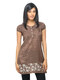

In [53]:
images = fashion['image']
metadata = fashion.remove_columns('image')
images[900]

In [ ]:
metadata = metadata.to_pandas()
metadata.head()

### Create the Sparse Vector Using BM25

In [ ]:
!pip install pinecone_text

In [ ]:
import nltk
nltk.download('punkt_tab')

In [ ]:
from pinecone_text.sparse import BM25Encoder

bm25 = BM25Encoder()
bm25.fit(metadata['productDisplayName'])
metadata['productDisplayName'][0]

In [ ]:
bm25.encode_queries(metadata['productDisplayName'][0])
bm25.encode_documents(metadata['productDisplayName'][0])

### Create the Dense Vector Using CLIP

In [ ]:
model = SentenceTransformer('sentence-transformers/clip-ViT-B-32', device=device)
model
dense_vec = model.encode([metadata['productDisplayName'][0]])
dense_vec.shape

In [ ]:
len(fashion)

### Create Embeddings Using Sparse and Dense

In [ ]:
batch_size = 100
fashion_data_num = 1000

for i in tqdm(range(0, min(fashion_data_num,len(fashion)), batch_size)):
    # find end of batch
    i_end = min(i+batch_size, len(fashion))
    # extract metadata batch
    meta_batch = metadata.iloc[i:i_end]
    meta_dict = meta_batch.to_dict(orient="records")
    # concatinate all metadata field except for id and year to form a single string
    meta_batch = [" ".join(x) for x in meta_batch.loc[:, ~meta_batch.columns.isin(['id', 'year'])].values.tolist()]
    # extract image batch
    img_batch = images[i:i_end]
    # create sparse BM25 vectors
    sparse_embeds = bm25.encode_documents([text for text in meta_batch])
    # create dense vectors
    dense_embeds = model.encode(img_batch).tolist()
    # create unique IDs
    ids = [str(x) for x in range(i, i_end)]

    upserts = []
    # loop through the data and create dictionaries for uploading documents to pinecone index
    for _id, sparse, dense, meta in zip(ids, sparse_embeds, dense_embeds, meta_dict):
        upserts.append({
            'id': _id,
            'sparse_values': sparse,
            'values': dense,
            'metadata': meta
        })
    # upload the documents to the new hybrid index
    index.upsert(upserts)

# show index description after uploading the documents
index.describe_index_stats()

### Run Your Query

In [ ]:
query = "dark blue french connection jeans for men"

sparse = bm25.encode_queries(query)
dense = model.encode(query).tolist()

result = index.query(
    top_k=14,
    vector=dense,
    sparse_vector=sparse,
    include_metadata=True
)

imgs = [images[int(r["id"])] for r in result["matches"]]
imgs

In [65]:
from IPython.core.display import HTML
from io import BytesIO
from base64 import b64encode

# function to display product images
def display_result(image_batch):
    figures = []
    for img in image_batch:
        b = BytesIO()
        img.save(b, format='png')
        figures.append(f'''
            <figure style="margin: 5px !important;">
              <img src="data:image/png;base64,{b64encode(b.getvalue()).decode('utf-8')}" style="width: 90px; height: 120px" >
            </figure>
        ''')
    return HTML(data=f'''
        <div style="display: flex; flex-flow: row wrap; text-align: center;">
        {''.join(figures)}
        </div>
    ''')

In [ ]:
display_result(imgs)

### Scaling the Hybrid Search

In [67]:
def hybrid_scale(dense, sparse, alpha: float):
    """Hybrid vector scaling using a convex combination

    alpha * dense + (1 - alpha) * sparse

    Args:
        dense: Array of floats representing
        sparse: a dict of `indices` and `values`
        alpha: float between 0 and 1 where 0 == sparse only
               and 1 == dense only
    """
    if alpha < 0 or alpha > 1:
        raise ValueError("Alpha must be between 0 and 1")
    # scale sparse and dense vectors to create hybrid search vecs
    hsparse = {
        'indices': sparse['indices'],
        'values':  [v * (1 - alpha) for v in sparse['values']]
    }
    hdense = [v * alpha for v in dense]
    return hdense, hsparse

### 1. More Dense

In [ ]:
question = "dark blue french connection jeans for men"
#Closer to 0==more sparse, closer to 1==more dense
hdense, hsparse = hybrid_scale(dense, sparse, alpha=1)
result = index.query(
    top_k=6,
    vector=hdense,
    sparse_vector=hsparse,
    include_metadata=True
)
imgs = [images[int(r["id"])] for r in result["matches"]]
display_result(imgs)

In [ ]:
for x in result["matches"]:
    print(x["metadata"]['productDisplayName'])

### 2. More Sparse

In [ ]:
question = "dark blue french connection jeans for men"
#Closer to 0==more sparse, closer to 1==more dense
hdense, hsparse = hybrid_scale(dense, sparse, alpha=0)
result = index.query(
    top_k=6,
    vector=hdense,
    sparse_vector=hsparse,
    include_metadata=True
)
imgs = [images[int(r["id"])] for r in result["matches"]]
display_result(imgs)

In [ ]:
for x in result["matches"]:
    print(x["metadata"]['productDisplayName'])

### More Dense or More Sparse?

In [ ]:
question = "dark blue french connection jeans for men"
#Closer to 0==more sparse, closer to 1==more dense
hdense, hsparse = hybrid_scale(dense, sparse, alpha=0.5)
result = index.query(
    top_k=6,
    vector=hdense,
    sparse_vector=hsparse,
    include_metadata=True
)
imgs = [images[int(r["id"])] for r in result["matches"]]
display_result(imgs)


In [ ]:
for x in result["matches"]:
    print(x["metadata"]['productDisplayName'])